# MAP545 - Deep Learning and Optimization
## Lab 2 - Optimization

In this lab, you will apply different techniques to find the best parameter values to a simple linear regression problem. After defining the empirical risk of the corresponding problem, you will apply a **Grid Search strategy** to output an approximation of the best parameter based on the data set. As this strategy cannot be used for most of real-world data sets, you will then implement and compare **Gradient Descent (GD)** and **Stochastic Gradient Descent (SGD)**. 

We will use the dataset `height_weight_genders.csv`. We have provided
sample code templates that already contain useful snippets of code required for this lab.
You will be working in this notebook by filling in the corresponding functions. The
notebook already provides a lot of template codes, as well as a code to load the data, normalize the
features, and visualize the results.
If you have time, you can look at the files `helpers.py` and `plots.py`, and make sure you understand them.

# Part 1 - Loading the data set and preliminary analysis

Enough with simulated data! In this lab, you will be happy to know that we will use a real-world data set. However, first things first, we are going to study a very simple one. We will try to build a linear model of the weight based on the height. Yes, this is crazy ML!

Here is a short (and very basic) video to illustrate Linear Regression : https://www.youtube.com/watch?v=CtsRRUddV2s&ab_channel=VisuallyExplained

In [38]:
import datetime
from helpers import *
import matplotlib.pyplot as plt

#Load the data
#You need to check that the file helpers.py and height_weight_genders.csv are in the current folder
height, weight, gender = load_data(filename = "height_weight_genders.csv", sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)

#Create the design matrix and the output vector 
y = weight
num_samples = len(y)
tx = np.c_[np.ones(num_samples), x]

We have at our disposal a dataset $\mathcal{D} = (x_i, y_i)_{i=1}^n$ with $n$ elements. In this exercise, we will implement a 1D linear regression which takes the following form:
$$
\forall j \in \{1, \cdots, n\}, y_j ≈ f(x_{j1} ) = w_0 + w_1 x_{j1} .
$$

We will use height as the input variable $x_{n1}$ and weight as the output variable $y_n$. The coefficients $w_0$ and $w_1$ are also called model parameters. Note this 1D regression contains 2 parameters: the slope and the intercept, this is the reason why tx is a set of 2D inputs, containing a column of 1.

Let us start by the array data type in NumPy. We store all the $(y_n, x_{n1})$ pairs in a vector and a matrix
as shown below:

$$
y =  \begin{bmatrix}
y_1 \\
y_2 \\
\vdots \\
y_n
\end{bmatrix} 
\qquad 
\tilde{X} = 
\begin{bmatrix}
1 & x_{11} \\
1 & x_{21} \\
\vdots & \vdots \\
1 & x_{n1} \\
\end{bmatrix} \,.
$$

We use the following cost function:
$$
\mathcal L : w \mapsto \frac{1}{2n} \| y - \tilde X w \|^2_2 \,.
$$


Text(0, 0.5, 'Weight')

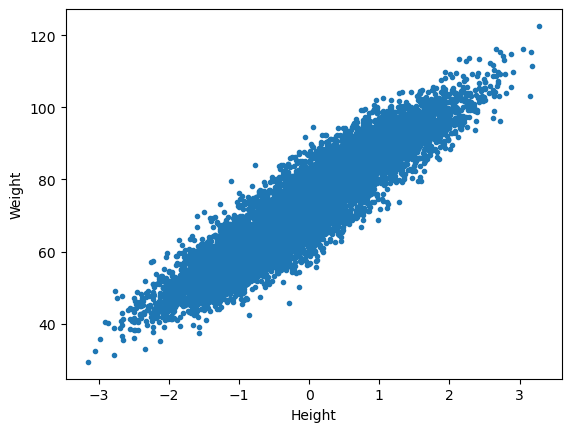

In [39]:
plt.plot(tx[:, 1], y, '.')

plt.xlabel('Height')
plt.ylabel('Weight')

**1) To understand this data format, answer the following warmup questions:**

- How many input variables are we going to use?
- How many observations does the data set contain?
- What does each column of $\tilde X$ represent ?
- What does each row of $\tilde X$ represent ?
- Why do we have 1’s in $\tilde X$ ?
- If we have heights and weights of 3 people, what would be the size of $y$ and $\tilde X$ ? What would
$\tilde X_{32}$ represent ? 


In helpers.py, we have already provided code to form arrays for $y$ and $\tilde X$. Have a look at the code, and make sure you understand how they are constructed.

- Number of Input Variables: In this 1D linear regression, we are using one input variable, which is height. This is indicated by the subscript "1" in $x_{n1}$.

- Number of Observations in the Dataset: The dataset contains $n$ observations, where $n$ is the number of $(y_n, x_{n1})$ pairs.


- Columns of $\tilde X$: The matrix $\tilde X$ has two columns. The first column contains all 1s, and the second column contains the values of the input variable, which in this case are the heights ($x_{n1}$) of individuals.


- Rows of $\tilde X$: Each row in $\tilde X$ corresponds to a single observation. For instance, the first row [1, x_{11}] represents the first observation with a height of $x_{11}$.



- Purpose of 1s in $\tilde X$: The 1s in the first column of $\tilde X$ are there to accommodate the intercept term $w_0$ in the linear equation $y = w_0 + w_1 x$. By having a column of 1s, we can use matrix multiplication to include this constant term in the model. Then the matrix equation is linear and with an intercept, the model fits better than  if we have to pass through the origin


- Size of $y$ and $\tilde X$ for 3 People; Meaning of $\tilde X_{32}$:


If we have data for 3 people, the size of $y$ would be a 3x1 vector, since $y$ contains the weights (output variable) for each person.

The size of $\tilde X$ would be 3x2, where each row corresponds to a person and the two columns represent the constant 1 (for intercept) and the height of the person.

$\tilde X_{32}$ would represent the height of the third person, as it is the value in the second column (which contains heights) of the third row (which corresponds to the third person).


In [5]:
print(f"n is equal to {num_samples}")

n is equal to 10000


**2) We want to build a linear model to predict the weight as a function of the height. We consider the square loss. What is the optimization problem we want to solve?**

Objective: Minimize the sum of squared errors between the actual weights ($y$) and the predicted weights ($\tilde{X}w$), where $w = [w_0, w_1]$ are the parameters of your linear model (with $w_0$ being the intercept and $w_1$ being the slope).

The optimization pb regarding the square loss function, or cost function, $\mathcal{L}$, is defined as: $\min_{w} \mathcal{L}(w) = \frac{1}{2n} \| y - \tilde{X}w \|^2_2$

Here, $\tilde{X}$ is your design matrix (with a column of 1s for the intercept term and a column for the height values), $y$ is the vector of actual weights, and $w$ is the vector of parameters (including both the intercept and slope). The notation $|\cdot|_2^2$ denotes the squared Euclidean norm, effectively summing the squares of the differences between actual and predicted values.





**3) Compute the cost functions by running the code below.**

In [7]:
def compute_loss(y, tx, w, loss="mse"):
    """Calculate the loss.

    You can calculate the loss using mse or mae.
    mse is used by default.
    """
    
    if loss == "mse":
        e = y - np.dot(tx, w)
        mse = (1 / (2 * y.shape[0])) * np.sum(e**2)
        return mse
    
    elif loss == "mae":
        e = y - np.dot(tx, w)
        mae =  np.mean(np.abs(e))
        return mae
    else:
        raise ValueError("\"loss\" argument must be either \"mse\" or \"mae\". {} not permitted".format(loss))



**4) Is it possible to solve exactly the previous optimization problem? Justify.**

It is possible to solve the optimization problem of minimizing the Mean Squared Error (MSE) in linear regression exactly under certain conditions. This problem has a closed-form solution known as the Normal Equation. The ability to solve this problem exactly depends on the properties of the design matrix $ \tilde{X}$.

The Normal Equation is given by: $ w = (\tilde{X}^T \tilde{X})^{-1} \tilde{X}^T y$

**Invertibility of $\tilde{X}^T \tilde{X}$:** The matrix $\tilde{X}^T \tilde{X}$ must be invertible (or non-singular). This generally requires that:
   - The columns of $\tilde{X}$ (the features) are linearly independent. If the features are linearly dependent (multicollinearity), the matrix $\tilde{X}^T \tilde{X}$ will not be invertible.
   - The number of observations n is greater than the number of features. If you have more features than observations, the matrix will be singular.


**5) Compute the least square estimate $\hat{\beta}$ and the value of the loss at optimum. Comment.**

In [8]:
def compute_exat_solution(y, tx):
     
    """Compute the exact solution for linear regression using the Normal Equation."""
    # Compute the matrix tx^T * tx
    txT_tx = np.dot(tx.T, tx)

    # Check if txT_tx is invertible
    if np.linalg.det(txT_tx) == 0:
        raise ValueError("The matrix tx^T * tx is not invertible. Cannot compute the exact solution.")

    # Compute the inverse of txT_tx
    txT_tx_inv = np.linalg.inv(txT_tx)

    # Compute the product of the inverse with tx^T
    w = np.dot(txT_tx_inv, np.dot(tx.T, y))

    return w


w_star = compute_exat_solution(y, tx)
loss_at_opt = compute_loss(y, tx, w_star)
print("The exact solution of the least square problem is", w_star)
print("The value of the loss at optimum is {:.2f}.".format(loss_at_opt))


The exact solution of the least square problem is [73.293922   13.47971243]
The value of the loss at optimum is 15.39.


### Comments:

Interpretation of Solution:
The values [73.29,13.48] represent the coefficients w0 and w1 in the linear regression model. In the context of predicting weight based on height, 
w0=73.29 is the intercept term, and w1=13.48 is the coefficient for the height variable. This implies that the model predicts a weight of 73.29 for a height of zero (which is a theoretical baseline) and an increase of 13.48 in weight for each unit increase in height.


Loss Value Significance:
A loss value of 15.39 indicates the average error (under the specific loss metric used, likely Mean Squared Error) made by the model in predicting the weight from height. It's essential to consider the scale of your target variable (weight) to assess whether this loss is low or high. 

It is not surprising that the loss at the optimum is not 0. On the contrary, it would be very suprising if the loss was 0: it would mean that there exists $w^*$ such that for any $i\in \lbrace 1, \dots, n \rbrace$, $y_i = w_0^{\star}+ w_1^{\star} x_i$. In other words, knowing the height of someone would allow us to determine his weight excatly.


In the following, we will compute and plot the **excess loss** $ \mathcal  L(w)- \mathcal L(w^{\star})$ instead of the loss, as most theoretical results provide guarantees on the excess loss.

# 2) Adopting a Grid Search approach

**6) We are now going to implement a Grid Search to find an approximate solution of our problem. Use the two following cells to do a Grid Search. What parameter can you tune to optimize the precision/computation time of Grid Search?**

Range of Parameter Values: This refers to the span of possible values for each parameter (e.g., the intercept w0 and the slope w1 in linear regression). Wider ranges allow for a more extensive search but increase computation time.

In [9]:
#Function that takes the data set and a list of parameters as input and output losses corresponding to each pair of parameters

def grid_search(y, tx, w0, w1):
    """Algorithm for grid search."""
    loss = np.zeros((len(w0), len(w1)))
    # compute loss for each combinationof w0 and w1.
    for ind_row, row in enumerate(w0):
        for ind_col, col in enumerate(w1):
            w = np.array([row, col])
            loss[ind_row, ind_col] = compute_loss(y, tx, w)-loss_at_opt
    return loss



Let us play with the grid search demo now!

Grid Search: loss*=0.11715740435280608, w0*=72.93233082706766, w1*=13.15789473684211, execution time=7.608 seconds


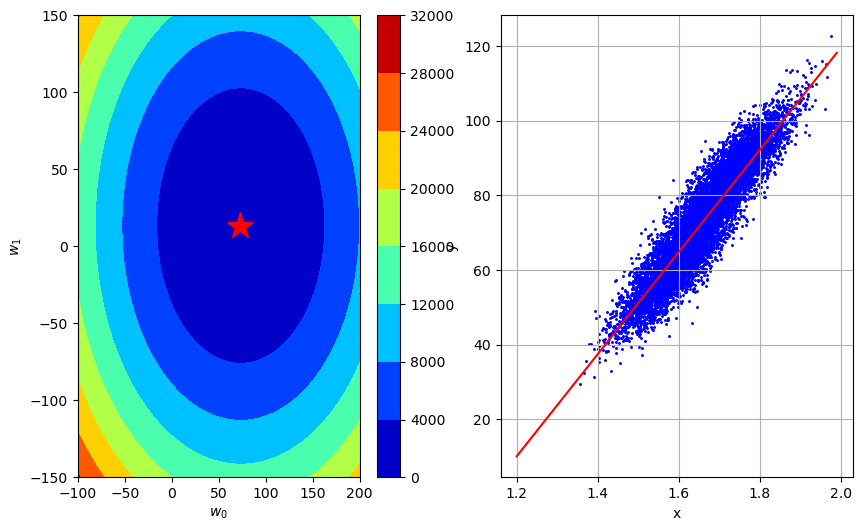

In [10]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=400)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print("Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
      l=loss_star, w0=w0_star, w1=w1_star, t=execution_time))

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
fig.savefig("grid_plot")  # Optional saving

Discuss with your peers :

- Does this look like a good estimate ? Why not ? What is the problem ? Why is the MSE plot not smooth ?
- Repeat the above exercise by changing the grid spacing to 10 instead of 50. Compare the new fit to the old one.
- How does increasing the number of values affect the computational cost ? How fast or slow does your code run ?

**The finner the grid, the morre precise the solution. However, the computational time increases very rapidly without a large improvement in this error: between a grid of size 100 and 1000, the error is divided by 24 while the time is multiplied by 107.**


In higher dimension the complexitiy increases even more, and this method cannot be used


# 3) Implementing Gradient Descent

Here is a short (and very basic) video to illustrate GD : https://www.youtube.com/watch?v=qg4PchTECck&ab_channel=VisuallyExplained

**7) The first thing to do when implementing a Gradient Descent is to define the gradient of the loss. Then,  fill in the functions `compute_gradient` below and check that your implementation is correct.**


The gradient of $\mathcal L$ is defined as following:
$$
\forall w \in \mathbb{R}^2, \nabla \mathcal L (w) = -\frac{1}{n} \tilde X^T (y - \tilde X w)
$$

In [12]:
def compute_gradient(y, tx, w):
    """Compute the gradient."""
    err = (y-tx@w)
    grad = -tx.T @ err/ y.shape[0]
    return grad

print("Let's verify the gradient in the optimum as a sanity check!")
grad_opt = compute_gradient(y, tx, w_star)
print("The gradient at optimum is ", grad_opt, "which is equal to zero.")

Let's verify the gradient in the optimum as a sanity check!
The gradient at optimum is  [-4.28869384e-13  2.34166557e-13] which is equal to zero.


**8) Fill in the function `gradient_descent` below.**

As we know from the lecture notes, the update rule for gradient descent at step $k$ is
$$
w_{k+1} = w_k - \gamma \nabla \mathcal L (w_k)
$$
where $\gamma > 0$ is the step size, and $\nabla \mathcal L \in \mathbb{R}^2$ is the gradient vector.


$\nabla_w \text{MSE} = \frac{-1}{n} \tilde{X}^T (y - \tilde{X}w)$

In [14]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """Gradient descent algorithm."""
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # compute excess loss and gradient
        grad = compute_gradient(y, tx, w)           #TODO OPERAND
        loss = compute_loss(y, tx, w) - loss_at_opt #TODO OPERAND
        # gradient w by descent update
        w = w - gamma * grad #TODO OPERAND
        # store w and loss
        ws.append(w)
        losses.append(loss)
        print("Gradient Descent({bi}/{ti}): excess loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=round(loss, 4), w0=round(w[0], 4), w1=round(w[1], 4)))
    return losses, ws


**Test your gradient descent function through gradient descent demo shown below.**

In [16]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 31
gamma = 0.8
#gamma = 0.5 ####for question 11
# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.s
start_time = datetime.datetime.now()
gradient_losses, gradient_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("Gradient Descent: execution time=%.3f seconds for %i iterations" %(exection_time, max_iters))

Gradient Descent(0/30): excess loss=2776.8508, w0=58.6351, w1=10.7838
Gradient Descent(1/30): excess loss=111.074, w0=70.3622, w1=12.9405
Gradient Descent(2/30): excess loss=4.443, w0=72.7076, w1=13.3719
Gradient Descent(3/30): excess loss=0.1777, w0=73.1767, w1=13.4581
Gradient Descent(4/30): excess loss=0.0071, w0=73.2705, w1=13.4754
Gradient Descent(5/30): excess loss=0.0003, w0=73.2892, w1=13.4788
Gradient Descent(6/30): excess loss=0.0, w0=73.293, w1=13.4795
Gradient Descent(7/30): excess loss=0.0, w0=73.2937, w1=13.4797
Gradient Descent(8/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descent(9/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descent(10/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descent(11/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descent(12/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descent(13/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descent(14/30): excess loss=0.0, w0=73.2939, w1=13.4797
Gradient Descen

In [17]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gradient_losses, gradient_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=32, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

## Comments: 

- Is the cost being minimized ?
- Is the algorithm converging ? What can be said about the convergence speed ?
- How good are the final values of $w_1$ and $w_0$ found ?

##############

- The difference between the loss and its optimum reaches machine precision after 13 iterations.
- The algorithm converges as the excess loss reaches zero after 6 iterations (or machine precision after 13 iterations). 
- The values of $w_0$ and $w_1$ are very good, thus the linear line approximated well the point cloud.

##############


# Ici seulement 7 iteration et on obtient une approximation de la meilleur solution ( bien + rapide que le grid)

**9) Plot the evolution of the logarithm of the excess loss as a function of the number of iterations. What can be said about the convergence speed ?**

In the following, we will compute and plot the **excess loss** $ \mathcal  L(w)- \mathcal L(w^{\star})$ instead of the loss, as most theoretical results provide guarantees on the excess loss.

The algorithm converges and the convergence is linear in a log scale


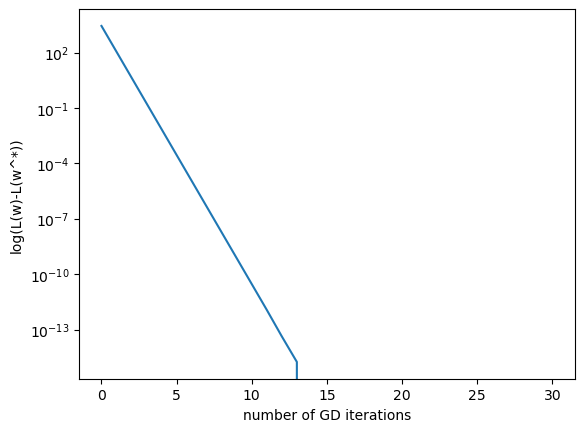

In [19]:
# Calculate the logarithm of the excess loss
plt.semilogy(gradient_losses)
plt.xlabel('number of GD iterations')
plt.ylabel('log(L(w)-L(w^*))')

print("The algorithm converges and the convergence is linear in a log scale")


**10) Did we expect this behavior for the loss? Justify.**

We converge exponentially fast (that's why with the log it is linear) 


The excess loss decays at an exponential rate, as predicted by theory (cf lecture):
$$\mathcal L(w_t)-\mathcal L(w^*) \le \frac{L}{2} \left(1-\gamma {\mu}\right)^t ||w_0-w^{\star}||^2$$

An exponential rate means that the error is **squared** when we double the number of iterations. Here for example, the excess loss is 0.0163 after 5 iterations, 9.68e-08 after 10 iterations, 3.55e-15 after 20 iterations

Consequently, in semi-log scale, we expect to have a **linear function**: this is what we observe on the graph above
$$\log\left(\mathcal L(w_t)- \mathcal L(w^*)\right) \le C -\gamma\mu t $$

The slope of the line should be $\gamma \mu$. So to check the theoretical convergence rate, we need to compute the constant $\mu$ (and, as a bonus, the constant $L$).  

**Computing the constant $L$ and $\mu$**

Recall that the risk is given by 
\begin{align}
\frac{1}{2n}|| \tilde X w-Y||^2
\end{align}
with a gradient equal to 
\begin{align}
- \frac{1}{n} \tilde X^T (Y - \tilde X w)
\end{align}
The Hessian matrix is given by 
\begin{align}
\frac{1}{n} \tilde X^T \tilde X
\end{align}

The Hessian matrix is equal to the identity for this problem, as shown by the next cell. Thus:
- its largest eigenvalue is 1, that is $L=1$
- its smallest eigenvalue is 1, that is $\mu=1$
- the condition number $\kappa = L/\mu$ is 1



H = $\frac{1}{n} \tilde{X}^T \tilde{X}$

In [21]:
# Computation of the Hessian matrix

hessian = np.dot(tx.T,tx)/y.shape[0]


print("The hessian is:\n", hessian)

The hessian is:
 [[ 1.00000000e+00 -1.13971055e-15]
 [-1.13971055e-15  1.00000000e+00]]


**11) Is the theoretical rate verified?**

HINT: Run gradient descent with a step size $\gamma=0.5$.

On the gaph above, we can check that the log excess loss, decays from 10^3 to 10^-12 in 25 iterations with a step size of 0.5.

Then the slope is -12-2/28=14/28=-1/2. The theoretical rate is verfified, -the slope is the same as the step size

**12) What is the maximal step size $\gamma$ you can choose? Try different values for $\gamma$. What do you notice?**

Gradient Descent(0/9): excess loss=2776.8508, w0=36.647, w1=6.7399
Gradient Descent(1/9): excess loss=694.2127, w0=54.9704, w1=10.1098
Gradient Descent(2/9): excess loss=173.5532, w0=64.1322, w1=11.7947
Gradient Descent(3/9): excess loss=43.3883, w0=68.7131, w1=12.6372
Gradient Descent(4/9): excess loss=10.8471, w0=71.0035, w1=13.0585
Gradient Descent(5/9): excess loss=2.7118, w0=72.1487, w1=13.2691
Gradient Descent(6/9): excess loss=0.6779, w0=72.7213, w1=13.3744
Gradient Descent(7/9): excess loss=0.1695, w0=73.0076, w1=13.4271
Gradient Descent(8/9): excess loss=0.0424, w0=73.1508, w1=13.4534
Gradient Descent(9/9): excess loss=0.0106, w0=73.2223, w1=13.4665
Gradient Descent(0/9): excess loss=2776.8508, w0=65.9645, w1=12.1317
Gradient Descent(1/9): excess loss=27.7685, w0=72.561, w1=13.3449
Gradient Descent(2/9): excess loss=0.2777, w0=73.2206, w1=13.4662
Gradient Descent(3/9): excess loss=0.0028, w0=73.2866, w1=13.4784
Gradient Descent(4/9): excess loss=0.0, w0=73.2932, w1=13.4796
Gra

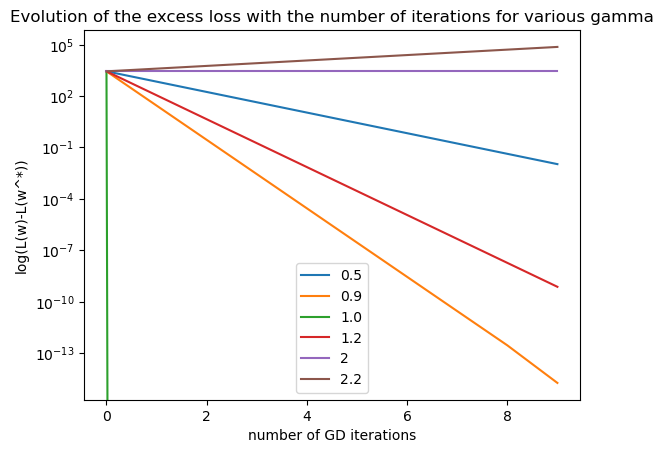

In [23]:
def plot_excess_loss_of_gd_for_different_gamma(gammas):
    for gamma in gammas:
        gradient_losses, _ = gradient_descent(y, tx, [0, 0], 10, gamma)
        plt.semilogy(gradient_losses)

    
    plt.title('Evolution of the excess loss with the number of iterations for various gamma')
    plt.xlabel('number of GD iterations')
    plt.ylabel('log(L(w)-L(w^*))')
    plt.legend(gammas)
    
plot_excess_loss_of_gd_for_different_gamma(gammas=[.5, .9, 1., 1.2, 2, 2.2])

As predicted by theory, there exists a maximum step size: **if the step size is larger than $2/L$, the GD algo diverges very quickly.**

Thus, we notice that if $\gamma > 2$, the Gradient Descent diverges. For a step size of 2, the error is constant: indeed, the algorithm oscillates between 2 models that have the same loss.


| GD error after | 5 iterations | 10 iterations |
|--- |---|---|
|$\gamma = 0.5$ | 2 |0.002|
|$\gamma = 1.5$ | 2.7| 0.002|
|$\gamma = 1.9$ |900 |337|
|$\gamma = 2$ |2776 |2776|
|$\gamma = 2.1$ | 7000 | 19000|

We have already noticed that the Hessian matrix of our problem is the identity (because the data has been standardised and we have only 2 dimensions). 

**We also observe that GD converges in one iteration with $\gamma=1$. Indeed, since the Hessian matrix is the identity, GD can be rewritten as a Newton method which is known to converge in one single iteration for quadratic problems whose condition number $\kappa=1$.**



# 4) Implementing Stochastic Gradient Descent

Stochastic Gradient Descent is a classical extension of the Gradient Descent, particularly useful when dealing with very large data sets (large number of observations). 

Here is a short (and very basic) video to illustrate SGD : https://www.youtube.com/watch?v=UmathvAKj80&ab_channel=VisuallyExplained

**13) Fill in the following code to implement Stochastic Gradient Descent.**

In [26]:
def compute_stochastic_gradient(y, tx, w, batch_size):
    """Compute a stochastic gradient from just few examples n and their corresponding y_n labels."""

    # Draw randomly a batch of indices
    batch = np.random.randint(0, len(y), batch_size) # TODO OPERAND
    
    # Extract the corresponding data
    y_batch = y[batch]      # TODO OPERAND
    tx_batch = tx[batch, :] # TODO OPERAND
    
    # Finally use the same formula as above to compute the gradient, this time only on the selected batch
    return compute_gradient(y_batch, tx_batch, w) #TODO LINE


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    
    w = initial_w
    ws = [w]
    losses = [compute_loss(y, tx, w)]
        
    for n_iter in range(max_iters):
        # Compute a stochastic gradient and loss
        grad = compute_stochastic_gradient(y, tx, w, batch_size) # TODO OPERAND
        # CONSTANT STEP SIZE
        w = w - gamma * grad  # TODO OPERAND
        
        # Calculate loss
        loss = compute_loss(y, tx, w)-loss_at_opt  # TODO OPERAND
        
        # Store w and loss
        ws.append(w)
        losses.append(loss)


    print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws


In [27]:
# Define the parameters of the algorithm.
max_iters = 100000
gamma = 0.8
batch_size = 16

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution ime=%.3f seconds for %i iterations" %(exection_time, max_iters))


SGD(99999/99999): loss=1.9550057165859176, w0=74.68041379965331, w1=12.069871334544173
SGD: execution ime=5.639 seconds for 100000 iterations


In [28]:
# Time Visualization
from ipywidgets import IntSlider, interact
def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses, sgd_ws, grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(gradient_ws)))

interactive(children=(IntSlider(value=1, description='n_iter', max=32, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

**14) Plot the evolution of the logarithm of the excess loss as a function of the number of iterations.**

In [ ]:
plt.semilogy(sgd_losses) #TODO LINE


plt.title('Evolution of the excess loss with the number of iterations')
plt.xlabel('number of SGD iterations')
plt.ylabel('log(L(w)-L(w^*))')

send(plt, 13)

**15) How does the choice of the step size impact the convergence of SGD?**

In [30]:
def plot_excess_loss_of_sgd_for_different_gamma(gammas):
    ############## TODO BLOCK
    for gamma in gammas:
        gradient_losses, _ = stochastic_gradient_descent(y, tx, [0, 0], 16, 100, gamma)
        plt.semilogy(gradient_losses)
    ############## END TODO BLOCK
    plt.title('Evolution of the excess loss with the number of iterations for gamma={}'.format(gamma))
    plt.xlabel('number of GD iterations')
    plt.ylabel('log(L(w)-L(w^*))')
    plt.legend(gammas)

SGD(99/99): loss=0.09636236016793376, w0=73.59540159700688, w1=13.798828047571353
SGD(99/99): loss=0.1734716332395756, w0=73.64270931845971, w1=13.954360382871862
SGD(99/99): loss=0.05157240075960168, w0=73.26032558269826, w1=13.160312869988973
SGD(99/99): loss=1.8706817757746048, w0=75.1640434840342, w1=12.985739566931628


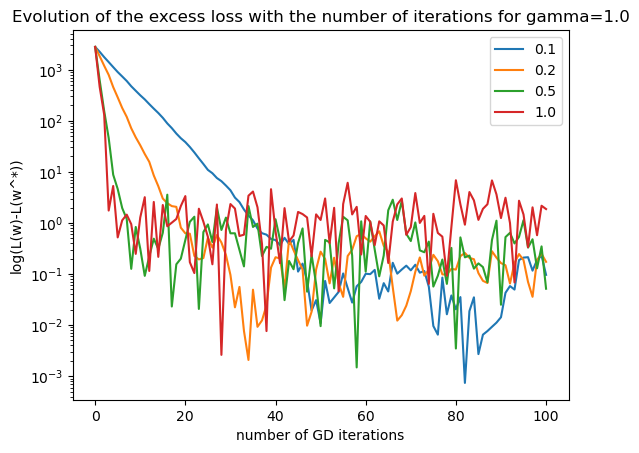

In [31]:
plot_excess_loss_of_sgd_for_different_gamma(gammas=[.1, .2, .5, 1.])

### Comments:

Considering a fix step size $\gamma$ results in a limiting excess loss which is non zero. Diminishing the value of $\gamma$ results in a smaller limiting excess loss. In order to obtain a consistent algorithm, **you need to consider a decreasing step size $\gamma$.**

In order to improve convergence, we use decaying steps, $\gamma_k = \frac{\gamma}{\sqrt{k}}$. **Using small step size reduces the impact of the noise in the gradients.**



**16) Plot the evolution of the log of the excess loss for SGD and for GD in the same graph. 
What is the complexity per iteration of GD, SGD? Compare the theoretical complexity and the time required per iteration for the algorithm. Interpret.**

In [32]:
num_samples

10000

Text(0, 0.5, 'log(L(w)-L(w^*))')

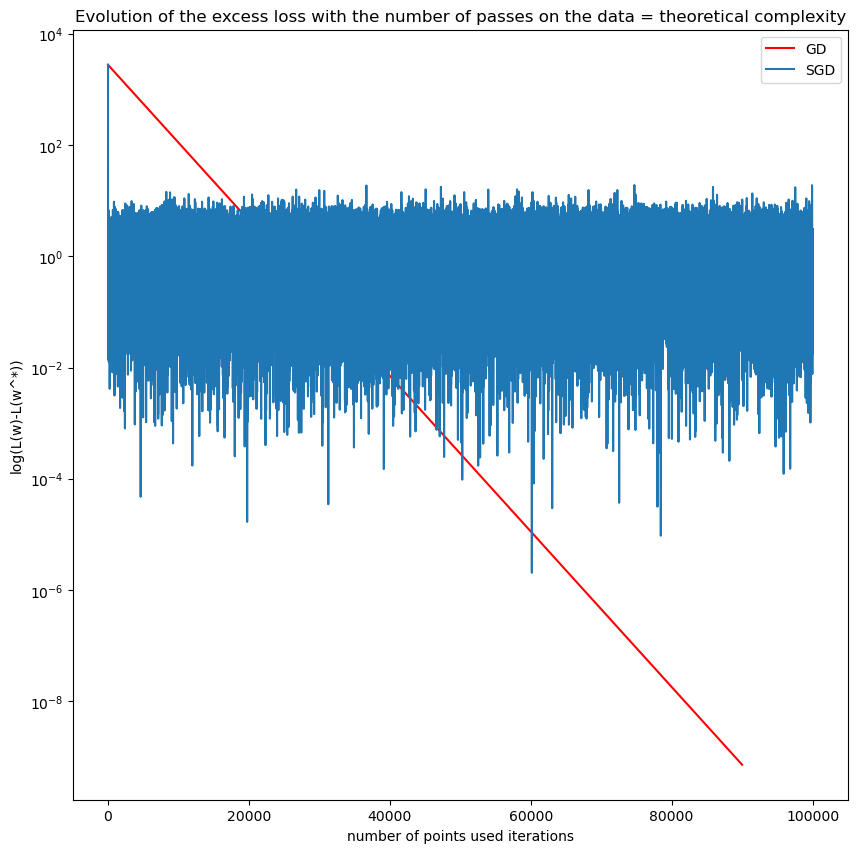

In [34]:
plt.figure(figsize=(10,10))
######## TODO BLOCK 
plt.semilogy(num_samples * np.arange(10), gradient_losses[:10], 'r', label='GD')
plt.semilogy(sgd_losses[:10 * num_samples], label='SGD')
plt.legend()
########### END TODO BLOCK 
plt.title('Evolution of the excess loss with the number of passes on the data = theoretical complexity')
plt.xlabel('number of points used iterations')
plt.ylabel('log(L(w)-L(w^*))')


## Comments:

The convergence of SGD is much slower than that of GD in terms of number of iterations. However, each SGD iteration only uses 1 observation, while each GD iteration uses the 10 000 observations at each step. In other words, the complexity of 1 step of GD is the same as the complexity of 10 000 steps of SGD.

For a step size of 1, the loss is 0.003 after 10000 iterations (one epoch), while it is 600 after 1 GD step (also one pass on all gradients). 

**SGD converges much faster that GD if we want a low precision. However, GD will reach a high precision (e.g., $10^{-15}$) faster than SGD**

**In machine learning, we do not care too much about very high precision: the empirical risk minimization problem that we are solving is itself only an approximation of the unknown (true) generalization risk.** SGD is thus the algorithm of choice.

Another approach is to use decaying step size for SGD. This way, when we get closer to the neighborhood of the optimal point, the step size is reduced, reducing oscillation and improving the convergence toward the optimum.

**17) Plot the evolution of the log of the excess loss for SGD with decaying step size, and for GD in the same graph.**

In [36]:
def stochastic_gradient_descent_decaying_step_sizes(y, tx, initial_w, batch_size, gammas):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    
    w = initial_w
    ws = [w]
    losses = [compute_loss(y, tx, w)-loss_at_opt]
        
    for n_iter in range(len(gammas)):
        # compute a stochastic gradient and loss with DECAYING STEP SIZE
        ########### TODO BLOCK 
        grad = compute_stochastic_gradient(y, tx, w, batch_size) 
        w = w - gammas[n_iter] * grad  # 
        
        # calculate loss
        loss = compute_loss(y, tx, w)-loss_at_opt
        
        # store w and loss
        ws.append(w)
        losses.append(loss)
        ########### END TODO BLOCK 

    print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws


sgd_losses, _ = stochastic_gradient_descent_decaying_step_sizes(y, tx, [0, 0], 16, 1/np.arange(1, 10 * num_samples+1))
sgd_losses_squared, _ = stochastic_gradient_descent_decaying_step_sizes(y, tx, [0, 0], 16, 1/np.sqrt(np.arange(1, 10 * num_samples+1)))



SGD(99999/99999): loss=2.0707453742829784e-06, w0=73.29205752981893, w1=13.48052805367648
SGD(99999/99999): loss=0.003442565964558497, w0=73.36621415325254, w1=13.520442974042718


Text(0, 0.5, 'log(L(w)-L(w^*))')

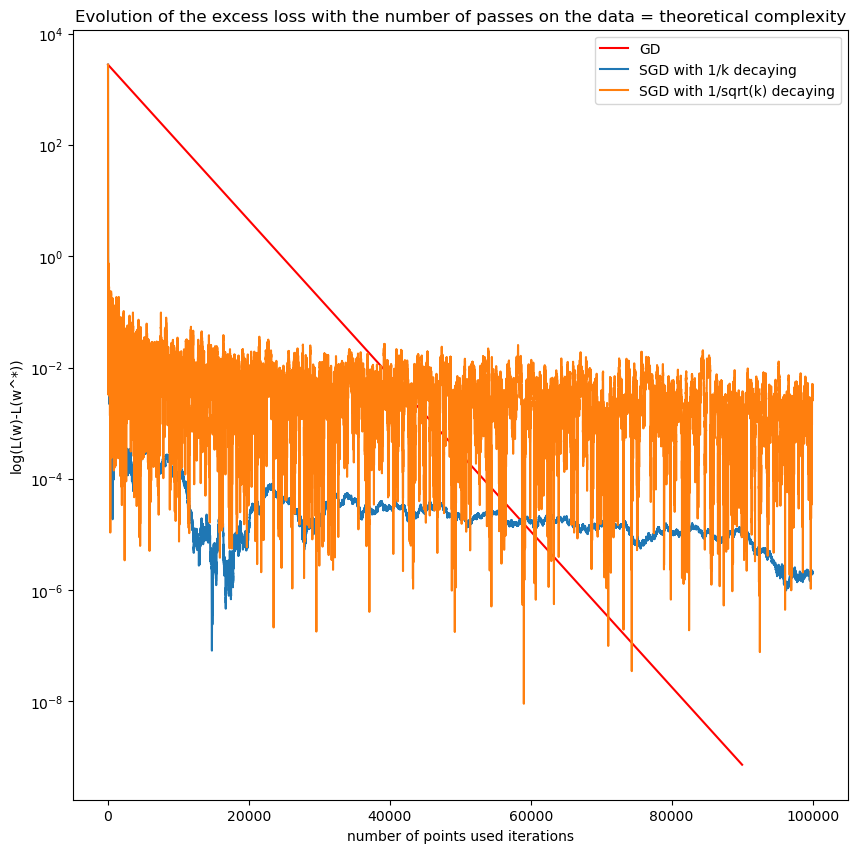

In [37]:
plt.figure(figsize=(10,10))

########### TODO BLOCK 
plt.semilogy(num_samples * np.arange(10), gradient_losses[:10], 'r', label='GD')
plt.semilogy(sgd_losses[:10 * num_samples], label='SGD with 1/k decaying')
plt.semilogy(sgd_losses_squared[:10 * num_samples], label='SGD with 1/sqrt(k) decaying')
plt.legend()
########### END TODO BLOCK 

plt.title('Evolution of the excess loss with the number of passes on the data = theoretical complexity')
plt.xlabel('number of points used iterations')
plt.ylabel('log(L(w)-L(w^*))')


As shown in the lecture notes, we could also compute the **averaged iterate**: 
$$\bar w_k= \frac{1}{k} \sum_{i=1}^k w_i,$$
which reduces the effect of the noise and improves a lot the convergence. No need to store all previous iterations, the average iterate $\bar w_k$ can be computed online via
$$\bar w_k= \frac{k-1}{k} \bar w_{k-1} +\frac{1}{k} w_k.$$

**18) Plot the evolution of the log of the excess loss for SGD with Polyak-Ruppert averaging, and for GD in the same graph.**

In [41]:
def stochastic_gradient_descent_rupert_averaging(y, tx, initial_w, batch_size, gammas):
    """Stochastic gradient descent."""
    # Define parameters to store w and loss
    
    w = initial_w
    ws = [w]
    losses = [compute_loss(y, tx, w)]
    
    wave = np.array(initial_w)
    
    for n_iter in range(len(gammas)):
        ########### TODO BLOCK         
        # compute a stochastic gradient and loss
        grad = compute_stochastic_gradient(y, tx, w, batch_size)
        w = w - gammas[n_iter] * grad  # CONSTANT STEP SIZE
        wave = n_iter * wave/(n_iter + 1) + np.array(w)/(n_iter + 1)
        # calculate loss
        loss = compute_loss(y, tx, wave)-loss_at_opt
        
        # store w and loss
        ws.append(wave)
        losses.append(loss)
        ########### END TODO BLOCK 

    print("SGD({bi}/{ti}): loss={l}, w0={w0}, w1={w1}".format(
              bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]))
    return losses, ws


SGD(99999/99999): loss=1.2041275470053847e-05, w0=73.29201152454392, w1=13.47989693634079
SGD(99999/99999): loss=6.787599232360719e-05, w0=73.2822363898478, w1=13.503194633972917


Text(0, 0.5, 'log(L(w)-L(w^*))')

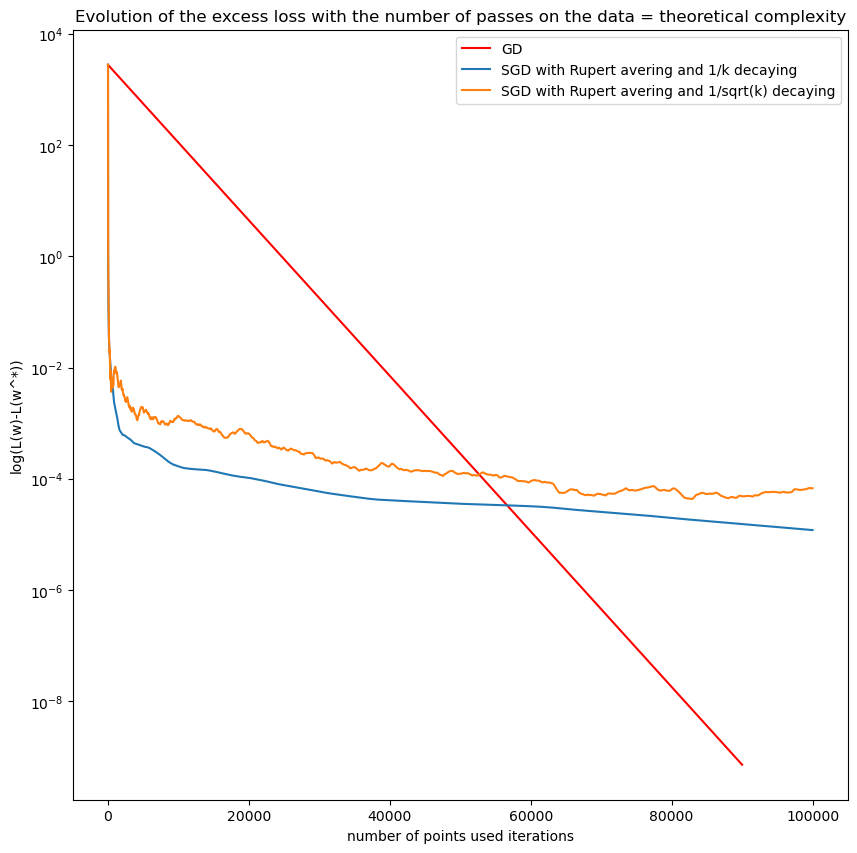

In [42]:
sgd_losses, _ = stochastic_gradient_descent_rupert_averaging(y, tx, [0, 0], 16, 1/np.arange(1, 10 * num_samples+1))
sgd_losses_sqrt, _ = stochastic_gradient_descent_rupert_averaging(y, tx, [0, 0], 16, 1/np.sqrt(np.arange(1, 10 * num_samples+1)))


plt.figure(figsize=(10,10))
plt.semilogy(num_samples * np.arange(10), gradient_losses[:10], 'r', label='GD')
plt.semilogy(sgd_losses[:10 * num_samples], label='SGD with Rupert avering and 1/k decaying')
plt.semilogy(sgd_losses_sqrt[:10 * num_samples], label='SGD with Rupert avering and 1/sqrt(k) decaying')

plt.legend()
plt.title('Evolution of the excess loss with the number of passes on the data = theoretical complexity')
plt.xlabel('number of points used iterations')
plt.ylabel('log(L(w)-L(w^*))')

In both final iterate and average iterate, we observe a good behavior of SGD that converges.
However, its convergence is still asymptotically slower than GD, and SGD is mostly useful in the first steps.

This is a reason why some people increase the batch size during the training to reduce the noise and hence getting faster along the training.

**19) We have solved a very specific problem since it is quadratic and the Hessian of the risk is the identity. For most problems, the hessian matrix won't be the identity. We could create a problem in which the Hessian is a non-diagonal covariance matrix, by having 2 explanatory variables that are not independent. For example, we can use height and height^3. You can re-run the entire lab with $tx$ re-defined with those two features.**

In [43]:
############ TODO BLOCK

feature_height2 = (tx[:,1]**3)
feature_height2 = 1/ np.std(feature_height2)*(feature_height2-np.mean(feature_height2))
tx2 = np.concatenate((tx, (feature_height2).reshape(-1,1)), axis=1)
tx2 = tx2[:, 1:]

H2 = tx2.T@tx2/num_samples
# note that directly replacing tx by tx2 does not directly work in the following code
H2
############# END TODO BLOCK

array([[1.        , 0.80968229],
       [0.80968229, 1.        ]])

In [ ]:
eigenvalues = np.linalg.eigvals(H2)
eigenvalues

This matrix has eigenvalues 1,81 and 0,19, thus a condition number of 9. We expect to have a maximal step size of 2/L, with L=1,81 that is around 1.1.